In [1]:

import pandas as pd

from config import BASE_DIR

RERUN = False

## Data

In [4]:


clustering_label = "composition"

## Van hecke article recunstruction

In [5]:


DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_500_words_22_05_2024.csv"
df = pd.read_csv(DATA_PATH)

df_non_nulls = df[~(df[clustering_label].isna())]
df_by_sentence = df_non_nulls

In [6]:

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


def hierarchical_clustering_analysis(data, composition_to_check, max_features=500, ngram_range=(2, 3)):
    data = data[df_by_sentence["composition"].isin(composition_to_check)]
    vectorizer = CountVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_features)
    X = vectorizer.fit_transform(data['text']).toarray()

    # Function to calculate the delta method distance
    def delta_method_distance(X):
        mean_vector = X.mean(axis=0)
        distances = pdist(X, metric=lambda u, v: np.sum(np.abs((u - mean_vector) - (v - mean_vector))))
        return squareform(distances)

    # Calculate the distance matrix
    distance_matrix = delta_method_distance(X)

    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    # Determine the color threshold
    max_distance = np.max(linkage_matrix[:, 2])
    color_threshold = max_distance * 0.5

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Generate cluster labels
    cluster_labels = fcluster(linkage_matrix, t=color_threshold, criterion='distance')

    # Plot PCA result with clustering
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'Delta method for {composition_to_check}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster Label')

    # Calculate and plot circles around each cluster
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        cluster_points = X_pca[cluster_labels == label]
        centroid = cluster_points.mean(axis=0)
        radius = np.max(np.sqrt(np.sum((cluster_points - centroid) ** 2, axis=1)))
        circle = Circle(centroid, radius, color='gray', fill=False, linestyle='--')
        plt.gca().add_patch(circle)

    for i, txt in enumerate(data["composition"]):
        plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)

    plt.show()

    plt.figure(figsize=(20, 15))
    dendrogram(linkage_matrix, labels=data['sentence_path'].values, leaf_rotation=0, leaf_font_size=10,
               orientation='right',
               color_threshold=color_threshold)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()






/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_36888/3736908750.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


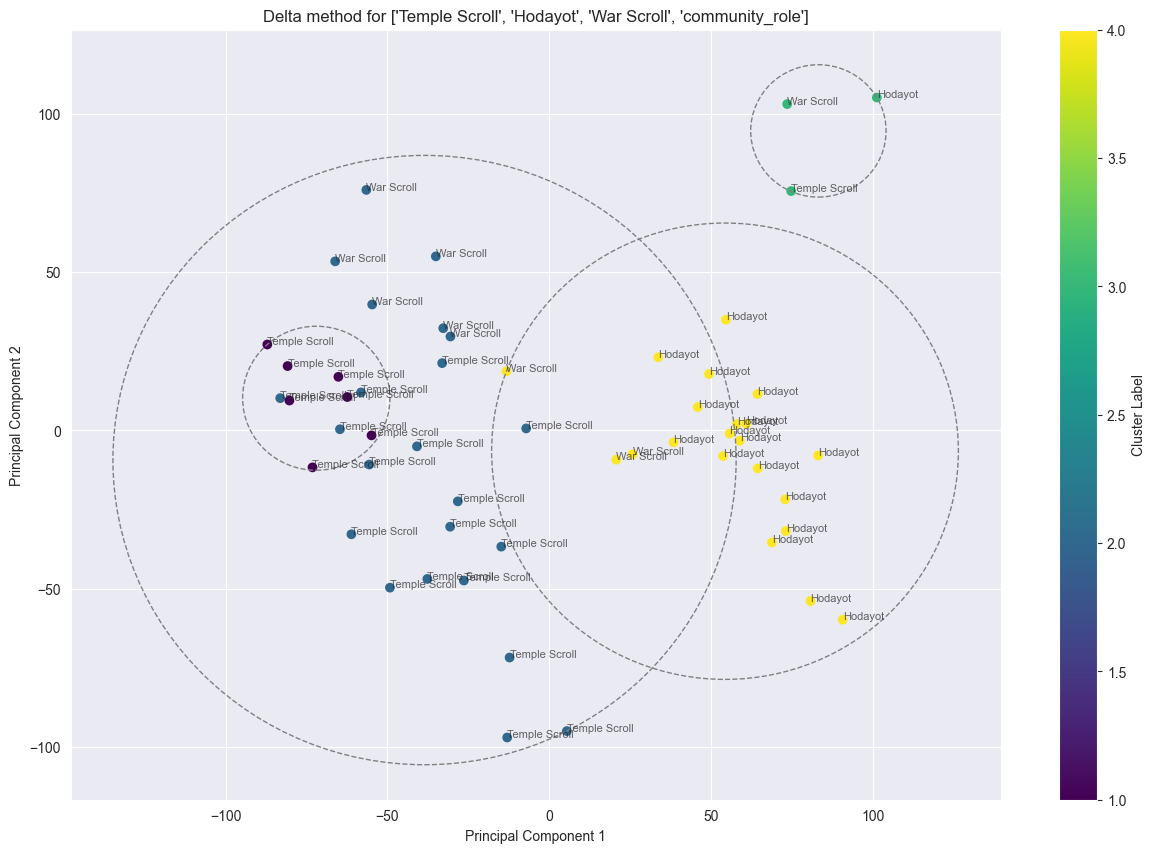

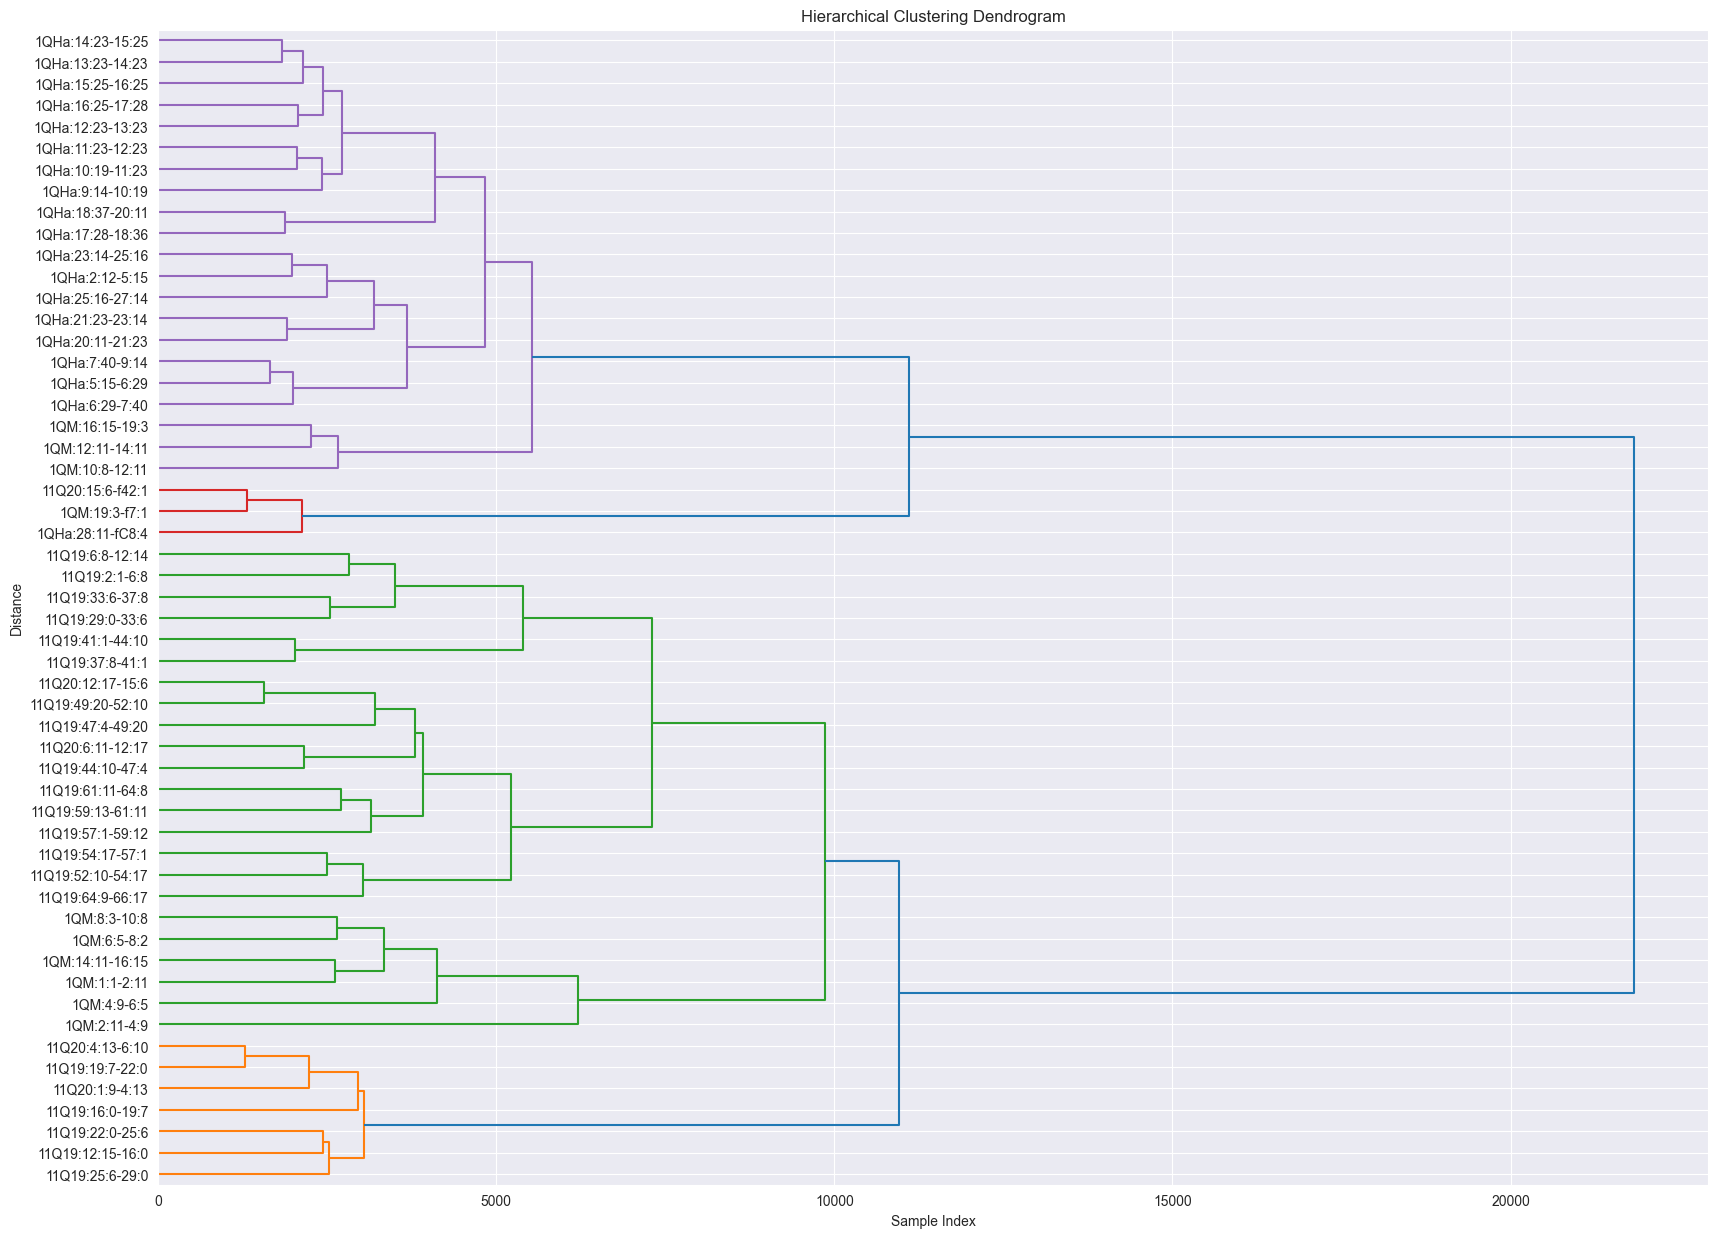

In [7]:
composition_to_check = ['Temple Scroll', 'Hodayot', 'War Scroll', 'community_role']
hierarchical_clustering_analysis(df_by_sentence, composition_to_check)

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_36888/3736908750.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


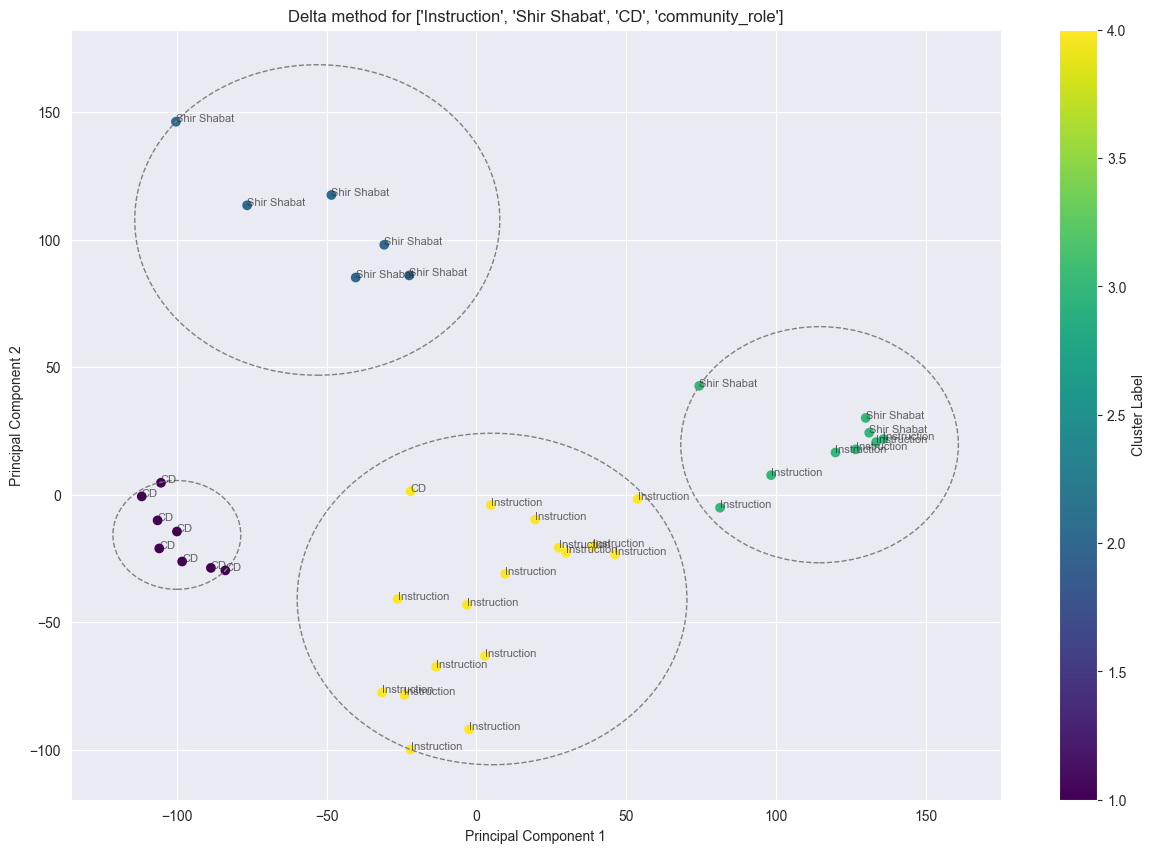

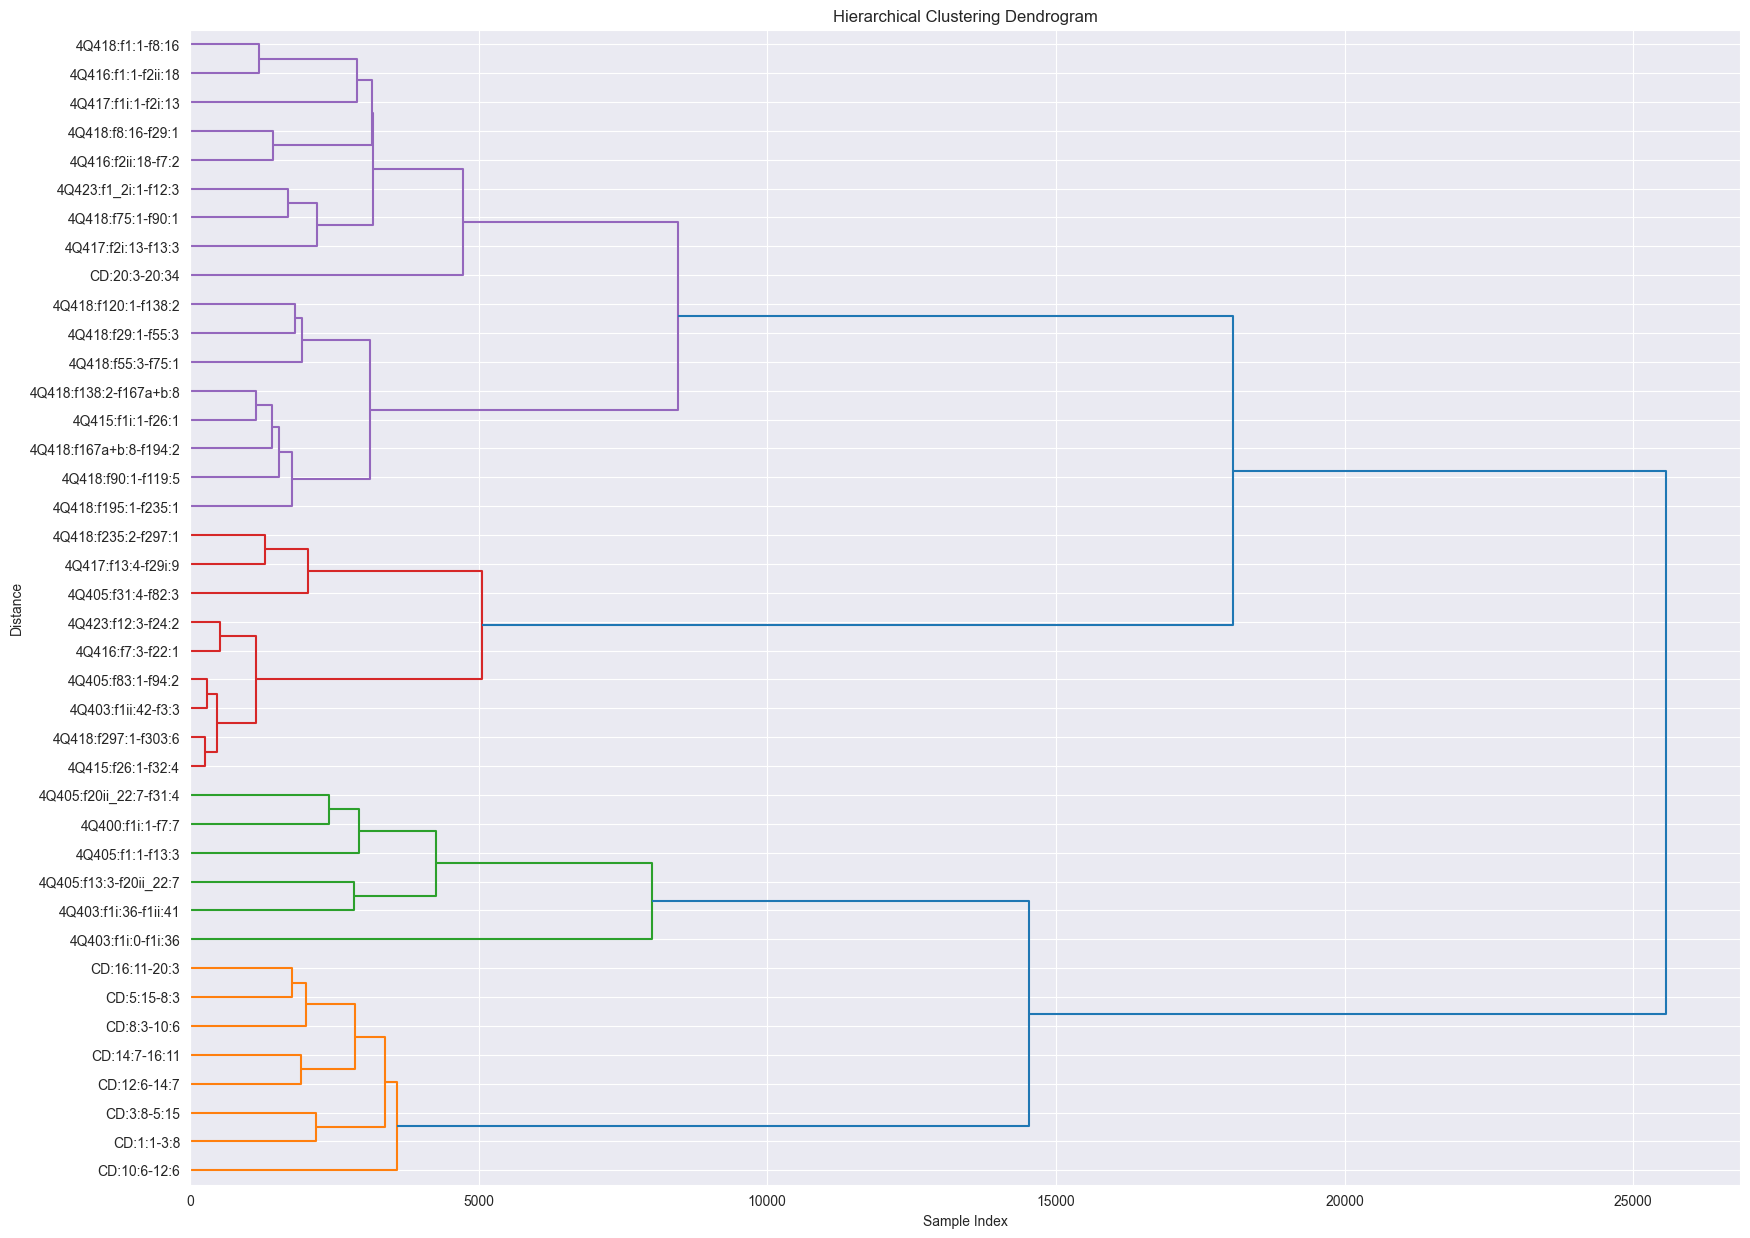

In [8]:
composition_to_check = ['Instruction', 'Shir Shabat', 'CD', 'community_role']
hierarchical_clustering_analysis(df_by_sentence, composition_to_check)